# Improve 

Cải thiện bằng cách thêm các lớp Dropout để giảm độ phức tạp của mô hình 
Dataset : https://www.kaggle.com/datasets/yasserhessein/dataset-alzheimer 

<strong>Có vẽ như model đã đúng , nếu ta chạy hết 5121 trong dữ liệu train thì độ chính xác của model tăng lên</strong>

## Import Toolkit

In [3]:
#import os libs
import os
import shutil
import itertools
import pathlib
from PIL import Image
#import Data handling
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
#import Deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , BatchNormalization , Dropout,Flatten , Activation
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint
import random
from tensorflow.keras.models import load_model

#Warnings
import warnings
warnings.filterwarnings('ignore')

## Upload Data

In [4]:
root_dir = 'Dataset/Dataset_Alzheimer_6400'
# Đường dẫn tới thư mục con 'train', 'val' và 'test'
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')
test_dir = os.path.join(root_dir, 'test')

### Tiền xử lí dữ liệu - Giảm chiều dữ liệu

In [5]:
img_size = (32 , 32)
batch_size = 8
img_shape = (img_size[0] , img_size[1] , 3)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_directory(train_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

valid_gen = ts_gen.flow_from_directory(val_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

test_gen = ts_gen.flow_from_directory(test_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = False , batch_size = batch_size)

Found 3583 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 515 images belonging to 4 classes.


## Show Sample From Train Data
### Input đầu vào : 2.000 mẫu (có thể tăng lên 3.400 mẫu)

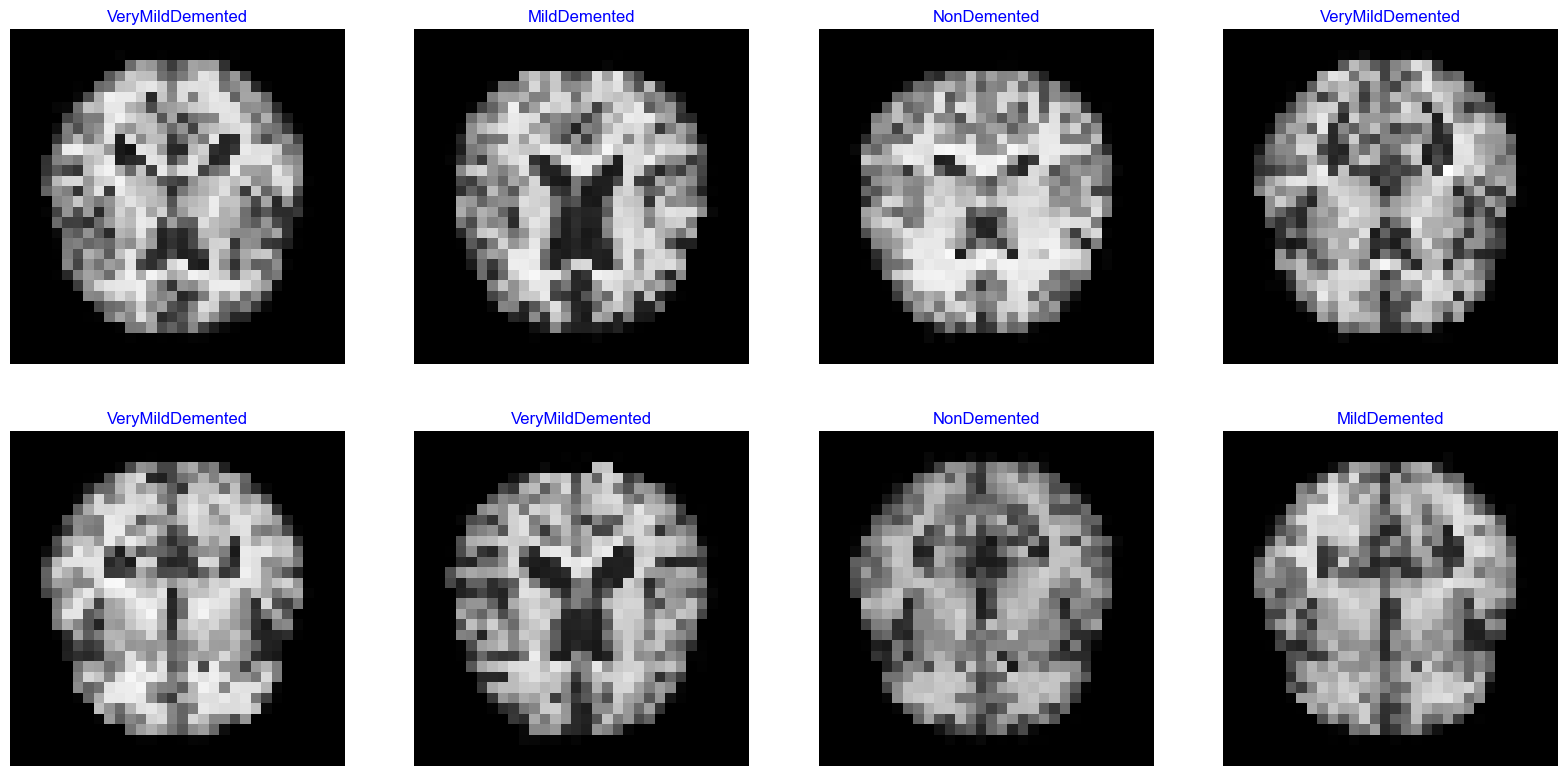

In [6]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)
num_samples = len(images)

plt.figure(figsize=(20, 20))

for i in range(min(16, num_samples)):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    class_index = np.argmax(labels[i]) # Lấy chỉ mục của lớp có xác suất cao nhất
    class_name = classes[class_index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()


## Model

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras import backend as K

def conv_bn_relu(x, filters, kernel_size, strides=(1, 1), padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def grouped_convolution_block(x, filters, strides, cardinality):
    grouped_channels = filters // cardinality
    groups = []
    for i in range(cardinality):
        group = conv_bn_relu(x, grouped_channels, (1, 1))
        group = conv_bn_relu(group, grouped_channels, (3, 3), strides=strides)
        groups.append(group)
    x = Add()(groups)
    return x

def build_convnext(input_shape=(32, 32, 3), num_classes=10, cardinality=32):
    inputs = Input(shape=input_shape)
    
    # Initial Convolution
    x = conv_bn_relu(inputs, 64, (3, 3))
    
    # Stacking ConvNeXt blocks
    x = grouped_convolution_block(x, 128, strides=(2, 2), cardinality=cardinality)
    x = grouped_convolution_block(x, 256, strides=(2, 2), cardinality=cardinality)
    x = grouped_convolution_block(x, 512, strides=(2, 2), cardinality=cardinality)
    
    # Global Average Pooling
    # Tương tự với các Flatten của CNN truyền thống 
    x = GlobalAveragePooling2D()(x)
    
    # Fully-connected layer
    # num_classes 
    num_classes = 4 # 4 nhãn  
    x = Dense(num_classes, activation='softmax')(x)
    
    # Create model
    model = Model(inputs, x, name='ConvNeXt')
    return model

# Create ConvNeXt model
convnext_model = build_convnext()

Trong mô hình ConvNeXt này, chúng ta không thực sự có lớp Flatten (làm phẳng) như trong các mô hình CNN truyền thống. Thay vào đó, chúng ta sử dụng lớp Global Average Pooling (GAP) để chuyển đổi các đặc trưng được trích xuất từ các lớp tích chập thành một vector duy nhất.

Trong hàm `build_convnext()`, sau khi chúng ta đã trích xuất các đặc trưng từ các lớp tích chập, chúng ta sử dụng lớp `GlobalAveragePooling2D()` để thực hiện việc này. Lớp này sẽ tính trung bình cộng của mỗi kênh trong đầu ra của lớp tích chập cuối cùng trên toàn bộ không gian đầu ra của nó, giảm kích thước của dữ liệu xuống còn một vector duy nhất với số lượng phần tử bằng số lượng kênh của đầu ra. Điều này có thể được coi như một cách tự nhiên để làm phẳng không gian đầu ra của các lớp tích chập.

Sau đó, chúng ta kết nối một lớp fully connected (Dense) với số lượng neuron bằng số lượng lớp output mà chúng ta muốn (trong trường hợp này là 4), và sử dụng hàm kích hoạt softmax để dự đoán xác suất của mỗi lớp. Điều này cho phép mô hình dự đoán xác suất của mỗi lớp cho mỗi mẫu đầu vào.

In [3]:
convnext_model.summary()

Model: "ConvNeXt"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32, 4) │        260 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32, 4) │        260 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32, 4) │        260 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32, 4) │        260 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32, 4) │        260 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32, 4) │        260 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32, 4) │        260 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 32, 32, 4) │        260 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32, 4) │        260 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32, 4) │        260 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32, 4) │        260 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32, 4) │        260 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32, 4) │        260 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 32, 32, 4) │        260 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 32, 32, 4) │        260 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 32, 32, 4) │        260 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 32, 32, 4) │        260 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 32, 32, 4) │        260 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 32, 32, 4) │        260 │ activation[0][0]

 Total params: 121,156 (473.27 KB)

 Trainable params: 117,444 (458.77 KB)

 Non-trainable params: 3,712 (14.50 KB)

## Compile and Fit Model

Thay thế các hàm tối ưu để đánh giá 
1. optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
2. optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
3. optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01)
4. optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
5. optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
6. optimizer = tf.keras.optimizers.Ftrl(learning_rate=0.001, learning_rate_power=-0.5, initial_accumulator_value=0.1, l1_regularization_strength=0.0, l2_regularization_strength=0.0)
7. optimizer = tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
8. optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)


In [27]:
# Tạo đối tượng optimizer  # SGD
# optimizer = tf.keras.optimizers.Adam()
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01)
# optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
# optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = tf.keras.optimizers.Ftrl(learning_rate=0.001, learning_rate_power=-0.5, initial_accumulator_value=0.1, l1_regularization_strength=0.0, l2_regularization_strength=0.0)
# optimizer = tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)


# Thiết lập ModelCheckpoint
save_best_only = True
checkpoint = ModelCheckpoint('models/ConvNeXt_model-{epoch:03d}.keras',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=save_best_only,
                             mode='auto')

# Xây dựng quy trình huấn luyện
convnext_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Huấn luyện mô hình với dữ liệu đã chuẩn bị
H = convnext_model.fit(
    train_gen,
    steps_per_epoch = train_gen.samples // train_gen.batch_size,
    validation_data = valid_gen,
    validation_steps = valid_gen.samples // valid_gen.batch_size,
    epochs = 30,
    callbacks=[checkpoint]
)

Epoch 1/30
446/447 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5292 - loss: 1.4554
Epoch 1: val_loss improved from inf to 0.72499, saving model to models/ConvNeXt_model-001.keras
447/447 ━━━━━━━━━━━━━━━━━━━━ 72s 57ms/step - accuracy: 0.5295 - loss: 1.4533 - val_accuracy: 0.6831 - val_loss: 0.7250
Epoch 2/30
  1/447 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.2500 - loss: 1.0780
Epoch 2: val_loss improved from 0.72499 to 0.50332, saving model to models/ConvNeXt_model-002.keras
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2500 - loss: 1.0780 - val_accuracy: 0.8571 - val_loss: 0.5033
Epoch 3/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7309 - loss: 0.6343
Epoch 3: val_loss did not improve from 0.50332
447/447 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.7310 - loss: 0.6343 - val_accuracy: 0.7185 - val_loss: 0.6586
Epoch 4/30
  1/447 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.7500 - loss: 0.4397
Epoch 4: val_loss improved from 0.50332 to 0.50121, 

## Model Performance

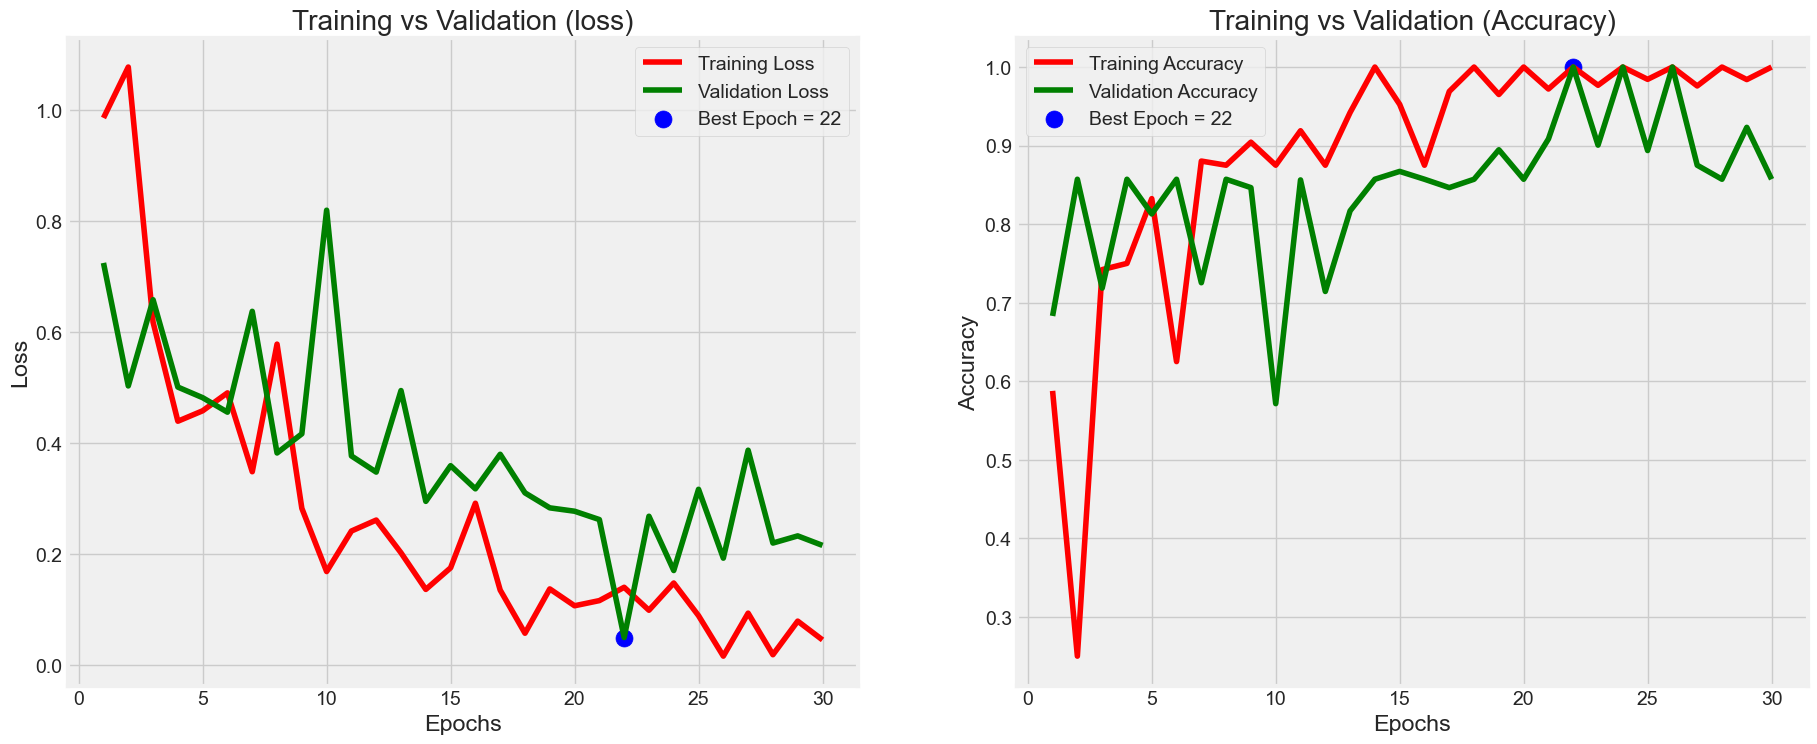

In [28]:
train_acc = H.history['accuracy']
train_loss = H.history['loss']

val_acc = H.history['val_accuracy']
val_loss = H.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r', label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss +1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r', label= 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s= 150 , c = 'blue' , label= acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

## Model Evaluation

In [29]:
train_score = convnext_model.evaluate(train_gen , steps= 32 , verbose = 1)
val_score = convnext_model.evaluate(valid_gen , steps = 32 , verbose = 1)
test_score = convnext_model.evaluate(test_gen , steps = 32 , verbose = 1)

print(f'Train loss = {train_score[0] }')
print(f'Train Accuracy = {train_score[1]}')
print(f'Validation loss = {val_score[0]}')
print(f'Validation Accuracy = {val_score[1]}')
print(f'Test loss = {test_score[0]}')
print(f'Test Accuracy = {test_score[1]}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0220
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9108 - loss: 0.2253
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9330 - loss: 0.1598
Train loss = 0.02257958985865116
Train Accuracy = 1.0
Validation loss = 0.23183253407478333
Validation Accuracy = 0.91015625
Test loss = 0.14564111828804016
Test Accuracy = 0.94140625


In [30]:
from sklearn.metrics import classification_report, confusion_matrix

# Dự đoán
preds = convnext_model.predict(test_gen)
preds = np.argmax(preds, axis=1)

# Lấy nhãn thật
true_labels = test_gen.classes

# Tính các chỉ số
report = classification_report(true_labels, preds, output_dict=True)

# In chỉ số f1, precision, recall
print("F1:", report['weighted avg']['f1-score'])
print("Precision:", report['weighted avg']['precision'])
print("Recall:", report['weighted avg']['recall'])

65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step
F1: 0.8856115862392898
Precision: 0.8890261328361355
Recall: 0.887378640776699


In [31]:
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90        73
           1       1.00      0.67      0.80         6
           2       0.88      0.95      0.91       256
           3       0.90      0.79      0.84       180

    accuracy                           0.89       515
   macro avg       0.92      0.83      0.86       515
weighted avg       0.89      0.89      0.89       515



## Model Prediction

## Confusion Matrix and Classification Report

In [37]:
# Load model 
from tensorflow.keras.models import load_model
best_model_ConvNeXt = load_model('models/ConvNeXt_model-022.keras')

#### Lấy mẫu ra từ test_gen để dự đoán 

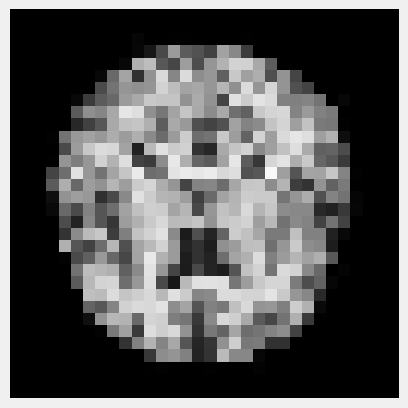

label encoder [0. 0. 1. 0.]
Nhãn ban đầu : NonDemented
(32, 32, 3)
(1, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Dự đoán: NonDemented


In [43]:
# Lấy một mẫu ngẫu nhiên từ test_gen
random_index = random.randint(0, len(test_gen) - 1)  
batch = test_gen[random_index] 

# In hình ảnh 
random_img = random.randint(0, len(batch) - 1)  
img = batch[0][random_img]
img = img.astype(float)/255
plt.imshow(img)
plt.axis('off')
plt.show()
# In ra nhãn 
label = batch[1][random_img]
print('label encoder', batch[1][0])
print('Nhãn ban đầu :', classes[np.argmax(label)])


# Chuyển đổi thành 4D tensor
img = batch[0][random_img]
print(img.shape)
img = np.expand_dims(img, axis=0)
print(img.shape)
# Dự đoán
pred = best_model_ConvNeXt.predict(img)
print('Dự đoán:', classes[np.argmax(pred)])

#### Lấy mẫu ảnh ra từ folder test để dự đoán 

In [81]:
# Lấy một file ảnh ngẫy nhiên trong folder test 
test_folder = 'Dataset/Dataset_Alzheimer_6400/test'
subfolders = [os.path.join(test_folder, subfolder) for subfolder in os.listdir(test_folder) if os.path.isdir(os.path.join(test_folder, subfolder))]
random_subfolder = random.choice(subfolders)
subfolder_images = os.listdir(random_subfolder)
random_image_name = random.choice(subfolder_images)
random_image_path = os.path.join(random_subfolder, random_image_name)

# In ra tên của ảnh được chọn
print("Tên file ảnh được chọn:", random_image_name)

# Load ảnh và chuyển thành tensor
img = load_img(random_image_path)
img = img.resize((32, 32))  # Resize ảnh về kích thước (32, 32)
img_array = img_to_array(img)
img_tensor = tf.expand_dims(img_array, axis=0)  # Thêm chiều batch
# print(img_tensor.shape)
# print(img_tensor)

# Load mô hình đã được lưu trữ
# Dự đoán nhãn của ảnh
predictions = best_model_ConvNeXt.predict(img_tensor)

# In ra nhãn dự đoán
print('Dự đoán:', classes[np.argmax(predictions)])


Tên file ảnh được chọn: ModerateDemented (17).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Dự đoán: VeryMildDemented


In [35]:
# Tính confusion matrix
conf_mat = confusion_matrix(true_labels, preds)

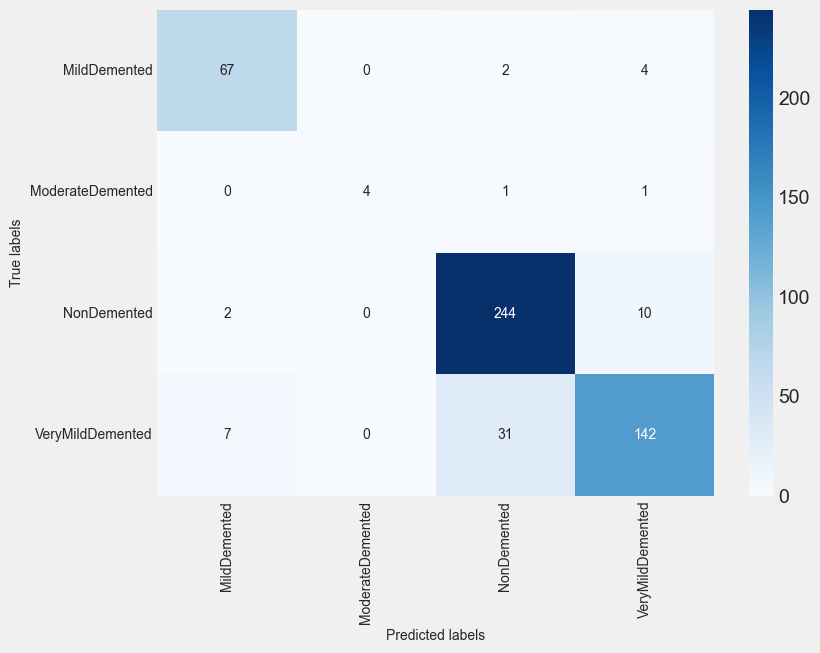

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# Assume you already have the confusion matrix (cm), sorted confusion matrix (sorted_cm), DataFrame (df_cm),
# true labels (true_labels), predicted labels (preds), and classes defined

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(true_labels, preds)

# Sắp xếp lại ma trận nhầm lẫn
sorted_cm = cm[np.argsort(classes)][:, np.argsort(classes)]

# Tạo dataframe từ ma trận nhầm lẫn đã sắp xếp lại
df_cm = pd.DataFrame(sorted_cm, index=classes, columns=classes)

# Set font size
font_size = 10

# Vẽ ma trận nhầm lẫn với font size đã điều chỉnh
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', annot_kws={"size": font_size})
plt.xlabel('Predicted labels', fontsize=font_size)
plt.ylabel('True labels', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.show()
